<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 10.4 - Analysing Streaming Data with Kafka

## Introduction

**Note**: this notebook is to be run in Google Colab on your Google Drive. It will not work locally on your computer.

The purpose of this lab is to gain experience in working with streaming data, using Apache Kafka installed on Google Colaboratory (Colab). You will see how a simple streaming dashboard data is created using the JupyterDash library and simulate live model scoring in monitoring a machine learning model.

Apache Kafka is an open-source distributed publish-subscribe messaging system that maintains streams of messages in topics. It has become a highly popular streaming platform for real-time applications.

In Google Colab, a virtual machine is automatically set up to execute your code. The maximum lifetime of such a machine is 12 hours. Note that notebooks will be disconnected from virutal machines if left idle. If this happens simple click on the Connect button to reconnect. If the kernel needs to be restarted (via the Runtime menu), variables may be lost but packages would not need to be reinstalled unless a new machine is assigned. 

https://research.google.com/colaboratory/faq.html

Sign into colab.research.google.com and choose the Upload tab and upload this notebook.  This will automatically create a folder called "Colab Notebooks" in your Google Drive (if it does not already exist). Next upload the dataset **"fraud_data.csv"** into this "Colab Notebooks" folder by going firstly to drive.google.com.

## Setup

The following code connects your Google Drive to this notebook. A new window will open to prompt you to allow the connection to occur.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Upon running the following cell you should see the name of this notebook and fraud_data.csv.

In [ ]:
!ls "/content/gdrive/My Drive/Colab Notebooks/"

Next download and install Kafka:

In [ ]:
!curl -sSOL https://downloads.apache.org/kafka/3.2.0/kafka_2.13-3.2.0.tgz 
!tar -xzf kafka_2.13-3.2.0.tgz

The kafka-python library will provide a Python-like interface to the Kafka platform:

In [ ]:
!pip install kafka-python

     |████████████████████████████████| 246 kB 5.4 MB/s 


Finally jupyter-dash will be used for interactive plotting in this notebook:

In [ ]:
!pip install jupyter-dash

     |████████████████████████████████| 7.3 MB 5.3 MB/s 
     |████████████████████████████████| 26.5 MB 1.3 MB/s 
     |████████████████████████████████| 357 kB 55.2 MB/s 
  Created wheel for dash-core-components: filename=dash_core_components-2.0.0-py3-none-any.whl size=3821 sha256=a36863d8345772004339967774a90d56b0ff01e103d36143e42423b3151cc68f
  Stored in directory: /root/.cache/pip/wheels/00/f9/c7/1a6437d794ed753ea9bc9079e761d4fc803a1f1f5d3697b9ec
  Created wheel for dash-html-components: filename=dash_html_components-2.0.0-py3-none-any.whl size=4089 sha256=e832935e698873008259833f8ef4866e08bdbee48f5f5a9f706d33ad5fcf028e
  Stored in directory: /root/.cache/pip/wheels/ec/6b/81/05aceabd8b27f724e2c96784016287cc1bfbc349ebfda451de
  Created wheel for dash-table: filename=dash_table-5.0.0-py3-none-any.whl size=3911 sha256=d5f1755dc10cd26f73cbbfb3750475529af61bcb918aecb952809fae5486c444
  Stored in directory: /root/.cache/pip/wheels/85/5d/4e/7c276b57992951dbe770bf5caad6448d0539c510663aef

In [ ]:
import time
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from kafka import KafkaProducer
from kafka import KafkaConsumer

from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import (Input, Output)
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import re
import warnings
warnings.filterwarnings('ignore')

We use the following shell command to run Zookeeper and Kafka. 

Apache ZooKeeper is used in distributed systems for service synchronisation, tracking the status of nodes in the Kafka cluster and maintaining a list of Kafka topics and messages.

In [ ]:
!./kafka_2.13-3.2.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.2.0/config/zookeeper.properties
!./kafka_2.13-3.2.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.2.0/config/server.properties
!echo "Waiting until zookeeper and kafka services are ready"
!sleep 10

Waiting until zookeeper and kafka services are ready


Verify that Kafka and Zookeeper are running (you should see four lines where the first two relate to Zookeeper and Kafka):

In [ ]:
!ps -ef | grep kafka

root         738       1 17 23:06 ?        00:00:02 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xlog:gc*:file=/content/kafka_2.13-3.0.0/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=100M -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/kafka_2.13-3.0.0/bin/../logs -Dlog4j.configuration=file:./kafka_2.13-3.0.0/bin/../config/log4j.properties -cp /content/kafka_2.13-3.0.0/bin/../libs/activation-1.1.1.jar:/content/kafka_2.13-3.0.0/bin/../libs/aopalliance-repackaged-2.6.1.jar:/content/kafka_2.13-3.0.0/bin/../libs/argparse4j-0.7.0.jar:/content/kafka_2.13-3.0.0/bin/../libs/audience-annotations-0.5.0.jar:/content/kafka_2.13-3.0.0/bin/../libs/commons-cli-1.4.jar:/content/kafka_2.13-3.0.0/bin/../libs/commons-lang3-3.8.1.jar:/content/kafka_2.13

## Loading the dataset

The dataset fraud_data.csv represents credit card transactions which have been labelled as fraudulent or non-fraudulent. It is synthetically generated and is based on the dataset at https://www.kaggle.com/kartik2112/fraud-detection. Some of the features based on transactions in the past 24 hours or 6 months have been engineered from the raw data.

- trans_datetime - date and time of the transaction
- cc_num - credit card number of the customer
- merchant - name of the merchant to which the customer is paying
- amt: amount of the transaction in $
- first: first name of the customer
- last: last name of the customer
- gender: gender of the customer
- street, city, state: address of the customer
- zip: zip code of the transaction
- lat: latitude of the customer
- long: longitude of the customer
- city_pop: population of the city where the customer is living
- job, age: job and age of the customer
- num_trans_60d, num_trans_24h: number of transactions by this credit card in the past 60 days, 24 hours respectively
- num_fraud_trans_24h: number of fraudulent transactions by this credit card in the past 24 hours
- avg_trans_amt_60d: the average number of transactions by this credit card in the past 60 days
- is_fraud: whether the transaction is fraud or not (1 - fraud, 0 - not fraud)

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/fraud_data.csv')
df.head()

,trans_datetime,cc_num,merchant,category,amount,firstname,lastname,gender,street,city,state,zip,lat,lon,city_pop,job,age,num_trans_60d,num_trans_24h,num_fraud_trans_24h,avg_trans_amt_60d,is_fraud
0,2019-01-01 00:14:37,2305336922781618,Harris Inc,gas_transport,50.79,Jeffrey,Rice,M,21447 Powell Circle,Moulton,IA,52572,40.6866,-92.6833,1132,Probation officer,58,1,6,0,50.79,0
1,2019-01-01 00:18:06,4428780983793657331,Lesch Ltd,shopping_pos,22.95,Richard,Waters,M,7683 Natasha Way Apt. 945,Waukesha,WI,53186,42.9993,-88.2196,95015,"Therapist, occupational",73,1,8,0,22.95,0
2,2019-01-01 00:40:50,213178850083780,Cummerata-Jones,gas_transport,70.53,Shawn,King,M,31493 Garcia Summit,Athena,OR,97813,45.8289,-118.4971,1302,Dealer,42,1,6,0,52.48,0
3,2019-01-01 00:47:55,3525668150756629,Heathcote LLC,shopping_net,101.35,Christopher,Choi,M,04611 Sandra Spring Suite 059,Rumely,MI,49826,46.3481,-87.0436,137,Film/video editor,28,424,5,0,69.34,0
4,2019-01-01 01:02:16,376028110684021,Wolf Inc,grocery_pos,89.11,Aaron,Murray,M,624 Hale Springs Apt. 572,Meadville,MO,64659,39.7795,-93.3014,964,Tourist information centre manager,44,1,3,0,66.03,0


## Perform EDA

**Exercise**: Perform some exploratory data analysis on the df dataframe.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96510 entries, 0 to 96509
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trans_datetime       96510 non-null  object 
 1   cc_num               96510 non-null  int64  
 2   merchant             96510 non-null  object 
 3   category             96510 non-null  object 
 4   amount               96510 non-null  float64
 5   firstname            96510 non-null  object 
 6   lastname             96510 non-null  object 
 7   gender               96510 non-null  object 
 8   street               96510 non-null  object 
 9   city                 96510 non-null  object 
 10  state                96510 non-null  object 
 11  zip                  96510 non-null  int64  
 12  lat                  96510 non-null  float64
 13  lon                  96510 non-null  float64
 14  city_pop             96510 non-null  int64  
 15  job                  96510 non-null 

In [ ]:
df.describe()

,cc_num,amount,zip,lat,lon,city_pop,age,num_trans_60d,num_trans_24h,num_fraud_trans_24h,avg_trans_amt_60d,is_fraud
count,9.651000e+04,96510.000000,96510.000000,96510.000000,96510.000000,9.651000e+04,96510.000000,96510.000000,96510.000000,96510.000000,96510.000000,96510.000000
mean,4.157534e+17,113.805738,48763.798777,38.550004,-90.236313,9.025761e+04,46.541913,198.859890,5.100187,0.373599,71.689247,0.100000
std,1.306572e+18,224.213433,26904.442608,5.089822,13.863794,3.046838e+05,17.633735,100.354014,3.196524,1.373979,37.235889,0.300002
min,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.800385e+14,11.090000,26041.000000,34.690200,-96.786900,7.430000e+02,33.000000,123.000000,3.000000,0.000000,54.670000,0.000000
50%,3.519607e+15,51.610000,48088.000000,39.354300,-87.461600,2.471000e+03,44.000000,194.000000,4.000000,0.000000,64.210000,0.000000
75%,4.634956e+15,96.607500,72011.000000,41.940400,-80.158000,2.032800e+04,58.000000,267.000000,7.000000,0.000000,83.880000,0.000000
max,4.992346e+18,11629.340000,99921.000000,66.693300,-67.950300,2.906700e+06,96.000000,557.000000,35.000000,15.000000,913.950000,1.000000


In [ ]:
df['category'].value_counts()

grocery_pos       10326
gas_transport      9726
shopping_pos       8856
shopping_net       8724
home               8616
kids_pets          7897
entertainment      6665
personal_care      6432
food_dining        6287
health_fitness     5994
misc_pos           5568
misc_net           5372
grocery_net        3182
travel             2865
Name: category, dtype: int64

In [ ]:
df.columns

Index(['trans_datetime', 'cc_num', 'merchant', 'category', 'amount',
       'firstname', 'lastname', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'lon', 'city_pop', 'job', 'age', 'num_trans_60d',
       'num_trans_24h', 'num_fraud_trans_24h', 'avg_trans_amt_60d',
       'is_fraud'],
      dtype='object')

**Question**: How balanced is this dataset?

In [ ]:
# ANSWER
df['is_fraud'].value_counts()

0    86859
1     9651
Name: is_fraud, dtype: int64

ANSWER: 90% of data is non-fraud.

Correlation matrix:

In [ ]:
df_numerical = df[['amount', 'lat', 'lon', 'city_pop', 'age', 'num_trans_60d', 
                   'num_trans_24h', 'num_fraud_trans_24h', 'avg_trans_amt_60d',
                   'is_fraud']]

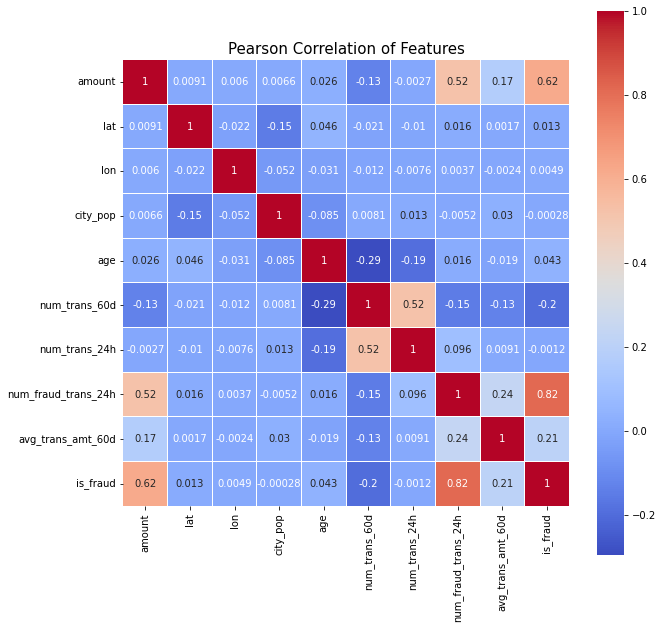

In [ ]:
colormap = plt.cm.coolwarm
plt.figure(figsize = (10, 10))
plt.title('Pearson Correlation of Features', size = 15)
sns.heatmap(df_numerical.astype(float).corr(),
            linewidths = 0.1,
            vmax = 1.0,
            square = True,
            cmap = colormap,
            linecolor = 'white',
            annot = True)
plt.show()

We see that amount, num_trans_60d, num_fraud_trans_24h, and num_trans_avg_amt_60d have the strongest correlation with the target variable is_fraud.

Since the dataset is large, we sample 1000 rows to obtain a pairplot.

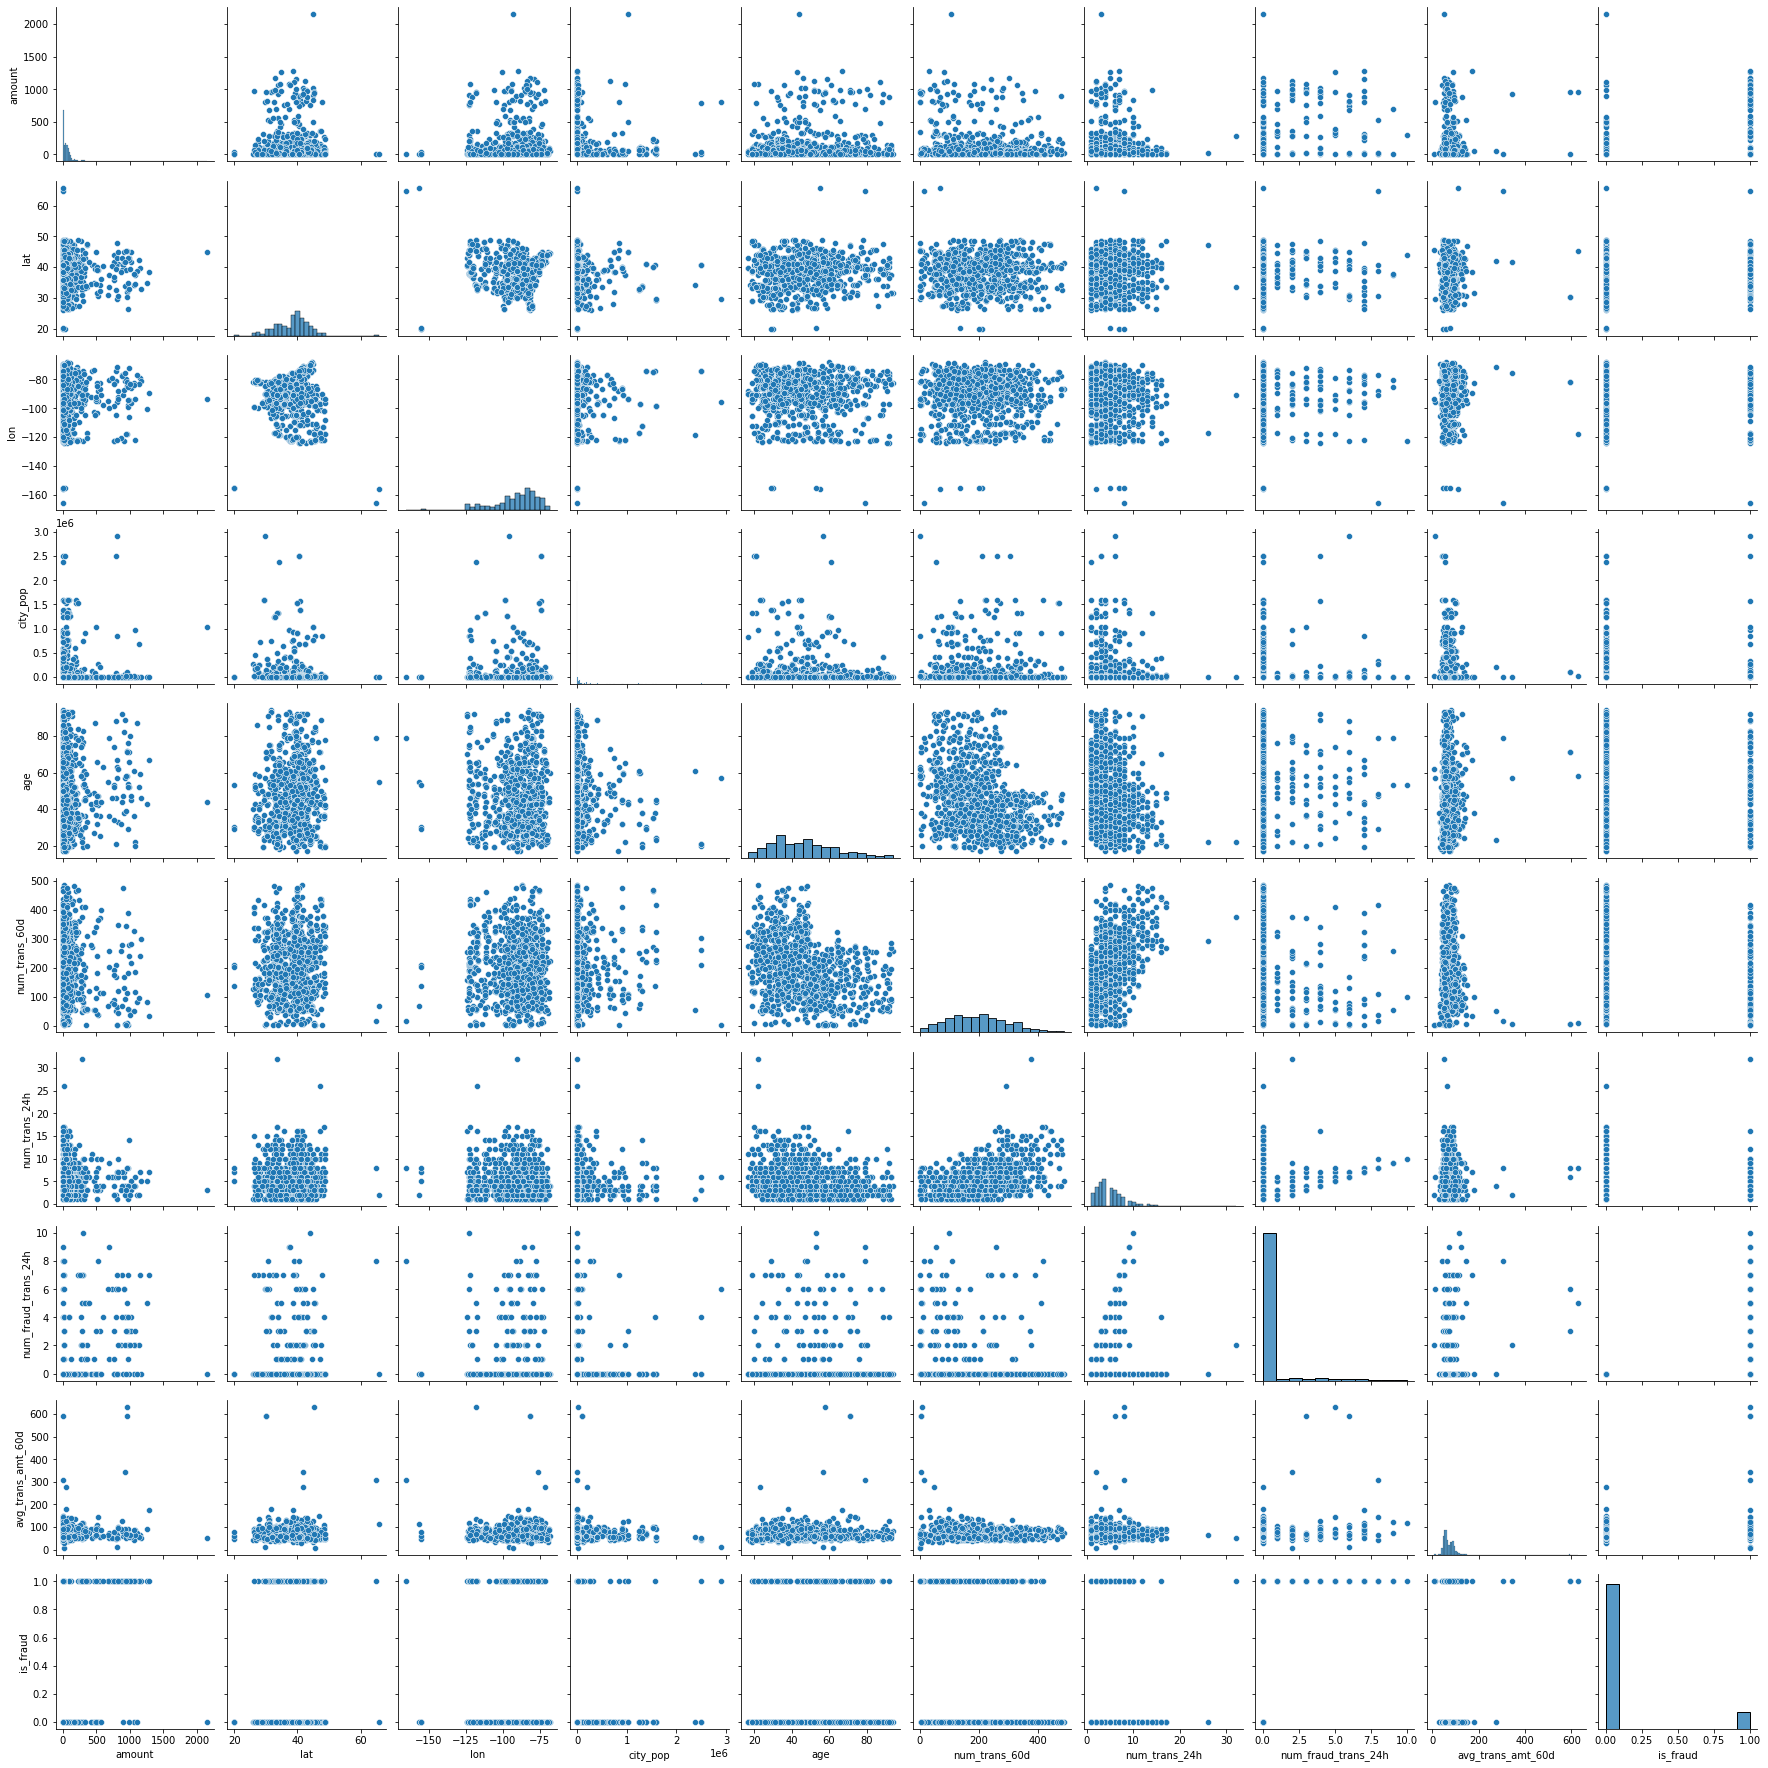

In [ ]:
sns.pairplot(df_numerical.sample(1000, random_state=0))
plt.show()

## Create topics

Kafka records are stored in *topics* which can be thought of as data feeds that one can subscribe to.

We shall create two topics on the Kafka platform.  

- One with customer information (called *customerinfo*)
- One with predictors that can be used for a fraud prediction algorithm (called *features*)

In [ ]:
!./kafka_2.13-3.2.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 2 --topic customerinfo
!./kafka_2.13-3.2.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic features


Created topic customerinfo.
Created topic features.


View their details:

In [ ]:
!./kafka_2.13-3.2.0/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic customerinfo
!./kafka_2.13-3.2.0/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic features

Topic: customerinfo	TopicId: Bp81EZHRTB-jKXU6aDKhoA	PartitionCount: 2	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: customerinfo	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
	Topic: customerinfo	Partition: 1	Leader: 0	Replicas: 0	Isr: 0
Topic: features	TopicId: eApiJ8AASMu8hMQ3RRv2Dw	PartitionCount: 1	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: features	Partition: 0	Leader: 0	Replicas: 0	Isr: 0


Next we create the records for these topics. The records need to be a list of key-value pairs. Here we will make the key the datetime (timestamp) of the transaction.

In [ ]:
timestamps = list(df['trans_datetime'][90000:].to_csv(index=False).split("\n"))
X_kafka = list(df.drop(['trans_datetime'],axis=1)[90000:].to_csv(index=False).split("\n"))


In [ ]:
predictors = ['amount', 'num_trans_60d', 'num_fraud_trans_24h', 'avg_trans_amt_60d']
featuredata = list(df[predictors + ['is_fraud']][90000:].to_csv(index=False).split("\n"))

In [ ]:
X_kafka

['cc_num,merchant,category,amount,firstname,lastname,gender,street,city,state,zip,lat,lon,city_pop,job,age,num_trans_60d,num_trans_24h,num_fraud_trans_24h,avg_trans_amt_60d,is_fraud',
 '377834944388609,Kuhic LLC,shopping_net,1061.02,Michael,Jackson,M,539 Underwood Divide,Pea Ridge,AR,72751,36.4539,-94.118,6434,Product designer,53,56,5,5,68.13,1',
 '639030014711,"Schumm, McLaughlin and Carter",food_dining,62.68,Stephen,Lopez,M,696 Matthew Ford Suite 157,Olmsted,IL,62970,37.1935,-89.0933,639,Mechanical engineer,38,111,5,0,92.62,0',
 '4155021259183870,Pollich LLC,home,59.16,Renee,Parrish,F,174 Jennifer Meadow Apt. 467,Mountain Park,OK,73559,34.7032,-98.9591,540,Research scientist (life sciences),37,215,12,0,61.68,0',
 '4874017206859125,"Mueller, Gerhold and Mueller",health_fitness,93.83,Lauren,Williams,F,065 Jones Stravenue,Lake Oswego,OR,97034,45.4093,-122.6847,42817,Planning and development surveyor,39,141,9,0,94.91,0',
 '3513618443244549,Streich Ltd,home,8.62,Amber,Perez,F,954 Reyes Wa

In [ ]:
featuredata

['amount,num_trans_60d,num_fraud_trans_24h,avg_trans_amt_60d,is_fraud',
 '1061.02,56,5,68.13,1',
 '62.68,111,0,92.62,0',
 '59.16,215,0,61.68,0',
 '93.83,141,0,94.91,0',
 '8.62,224,0,70.26,0',
 '73.3,217,0,92.72,0',
 '9.92,188,0,85.84,0',
 '409.2,56,6,68.13,1',
 '53.29,107,0,99.47,0',
 '1.17,276,0,108.88,0',
 '21.46,158,0,58.25,0',
 '38.56,282,0,68.59,0',
 '2.24,249,0,51.68,0',
 '35.1,337,0,90.32,0',
 '7.95,232,0,62.61,0',
 '244.39,336,0,79.15,0',
 '43.25,177,0,90.78,0',
 '6.3,118,0,55.08,0',
 '3.11,283,0,43.19,0',
 '79.71,265,0,47.38,0',
 '79.34,229,0,95.37,0',
 '9.3,244,0,43.38,0',
 '54.6,152,0,51.05,0',
 '6.38,241,0,49.52,0',
 '436.63,271,0,50.39,0',
 '2.48,280,0,54.8,0',
 '77.24,215,0,94.13,0',
 '66.93,65,0,87.91,0',
 '69.43,112,0,99.0,0',
 '9.16,1,0,9.16,1',
 '71.88,289,0,53.63,0',
 '84.37,155,0,37.36,0',
 '53.54,230,0,79.18,0',
 '6.71,167,0,55.95,0',
 '183.99,58,0,55.73,0',
 '72.07,185,0,90.52,0',
 '5.48,188,0,61.51,0',
 '26.63,164,0,53.14,0',
 '104.55,111,0,124.15,0',
 '64.24,261

The following helper functions will help write messages into each topic.

In [ ]:
def error_callback(exc):
    raise Exception('Error while sending data to kafka: {0}'.format(str(exc)))

def write_to_kafka(topic_name, items):
  count=0
  producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'])
  for key, message in items:
    producer.send(topic_name, key=key.encode('utf-8'), 
                  value=message.encode('utf-8')).add_errback(error_callback)
    count+=1
  producer.flush()
  print("Wrote {0} messages into topic: {1}".format(count, topic_name))

To start with we write 5 messages to each topic.

In [ ]:
write_to_kafka("customerinfo", zip(timestamps[1:6], X_kafka[1:6]))
write_to_kafka("features", zip(timestamps[1:6], featuredata[1:6]))

Wrote 5 messages into topic: customerinfo
Wrote 5 messages into topic: features


The zip function pairs up the timestamps with data into tuples.

Run the following shell command to view one of the topics. You will need to interrupt execution of the cell after the five messages have appeared.

In [ ]:
! /content/kafka_2.13-3.2.0/bin/kafka-console-consumer.sh \
--bootstrap-server localhost:9092 \
--topic features \
--from-beginning

1061.02,56,5,68.13,1
62.68,111,0,92.62,0
59.16,215,0,61.68,0
93.83,141,0,94.91,0
8.62,224,0,70.26,0
Processed a total of 5 messages


## Subscribing to topics
To start with we subscribe to both topics with the same consumer.

In [ ]:
kafka_bootstrap_servers = 'localhost:9092'
topics = ['customerinfo', 'features']

In [ ]:
consumer = KafkaConsumer(
    *topics,
    bootstrap_servers=kafka_bootstrap_servers,
    auto_offset_reset='earliest',
    enable_auto_commit=True)

In [ ]:
consumer.config

{'api_version': (2, 5, 0),
 'api_version_auto_timeout_ms': 2000,
 'auto_commit_interval_ms': 5000,
 'auto_offset_reset': 'earliest',
 'bootstrap_servers': 'localhost:9092',
 'check_crcs': True,
 'client_id': 'kafka-python-2.0.2',
 'connections_max_idle_ms': 540000,
 'consumer_timeout_ms': inf,
 'default_offset_commit_callback': <function kafka.consumer.group.KafkaConsumer.<lambda>>,
 'enable_auto_commit': True,
 'exclude_internal_topics': True,
 'fetch_max_bytes': 52428800,
 'fetch_max_wait_ms': 500,
 'fetch_min_bytes': 1,
 'group_id': None,
 'heartbeat_interval_ms': 3000,
 'key_deserializer': None,
 'legacy_iterator': False,
 'max_in_flight_requests_per_connection': 5,
 'max_partition_fetch_bytes': 1048576,
 'max_poll_interval_ms': 300000,
 'max_poll_records': 500,
 'metadata_max_age_ms': 300000,
 'metric_group_prefix': 'consumer',
 'metric_reporters': [],
 'metrics_num_samples': 2,
 'metrics_sample_window_ms': 30000,
 'partition_assignment_strategy': (kafka.coordinator.assignors.rang

The following cell shows the message, key and value of records obtained by the consumer. Stop running of the cell once ten messages have been displayed.

In [ ]:
for message in consumer:
  print("message: ", message)
  print("key: ", message.key)
  print("value: ", message.value.decode('utf-8'))
  time.sleep(2)

message:  ConsumerRecord(topic='customerinfo', partition=0, offset=0, timestamp=1640732995178, timestamp_type=0, key=b'2020-12-01 22:17:33', value=b'377834944388609,Kuhic LLC,shopping_net,1061.02,Michael,Jackson,M,539 Underwood Divide,Pea Ridge,AR,72751,36.4539,-94.118,6434,Product designer,53,56,5,5,68.13,1', headers=[], checksum=None, serialized_key_size=19, serialized_value_size=160, serialized_header_size=-1)
key:  b'2020-12-01 22:17:33'
value:  377834944388609,Kuhic LLC,shopping_net,1061.02,Michael,Jackson,M,539 Underwood Divide,Pea Ridge,AR,72751,36.4539,-94.118,6434,Product designer,53,56,5,5,68.13,1
message:  ConsumerRecord(topic='customerinfo', partition=1, offset=0, timestamp=1640732995179, timestamp_type=0, key=b'2020-12-01 22:23:27', value=b'639030014711,"Schumm, McLaughlin and Carter",food_dining,62.68,Stephen,Lopez,M,696 Matthew Ford Suite 157,Olmsted,IL,62970,37.1935,-89.0933,639,Mechanical engineer,38,111,5,0,92.62,0', headers=[], checksum=None, serialized_key_size=19, 

KeyboardInterrupt: ignored

**Question**: In which order have the records come into the consumer and are the records sorted within each topic? 

**Answer**: The records are sorted within each partition but not necessarily within a topic. One topic's results are shown followed by another.

For the next section we delete and recreate our topics, this time each with one partition.

In [ ]:
!./kafka_2.13-3.2.0/bin/kafka-topics.sh --delete --bootstrap-server 127.0.0.1:9092 --topic customerinfo
!./kafka_2.13-3.2.0/bin/kafka-topics.sh --delete --bootstrap-server 127.0.0.1:9092 --topic features


In [ ]:
!./kafka_2.13-3.2.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic customerinfo
!./kafka_2.13-3.2.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic features


Created topic customerinfo.
Created topic features.


In [ ]:
!./kafka_2.13-3.2.0/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic customerinfo
!./kafka_2.13-3.2.0/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic features

Topic: customerinfo	TopicId: sKIKJ0YMTKKRxWY0NCHlJw	PartitionCount: 1	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: customerinfo	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
Topic: features	TopicId: Co_YV0cEQNaOWEXBpUZjAg	PartitionCount: 1	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: features	Partition: 0	Leader: 0	Replicas: 0	Isr: 0


## Creating a map showing the incoming stream

This time we write more messages to each topic.

In [ ]:
write_to_kafka("customerinfo", zip(timestamps[1:], X_kafka[1:]))

Wrote 6511 messages into topic: customerinfo


**Exercise**: write featuredata[1:] to the topic "features"

In [ ]:
# ANSWER:
write_to_kafka("features", zip(timestamps[1:], featuredata[1:]))

Wrote 6511 messages into topic: features


In [ ]:
consumer = KafkaConsumer(
    'customerinfo',
    bootstrap_servers=kafka_bootstrap_servers,
    auto_offset_reset='earliest',
    enable_auto_commit=True)

Run the following cell to see if the first 20 latitude and longitude values are accessible.

In [ ]:
df_received = pd.DataFrame(columns = ['lat', 'lon'])
count = 0
for message in consumer:
  count = count + 1
  x = re.split(r",(?=(?:[^\"]*\"[^\"]*\")*[^\"]*$)", message.value.decode('utf-8'))
  #source: https://stackoverflow.com/questions/18893390/splitting-on-comma-outside-quotes
  #this regular expression allows one to split the record only on commas occurring outside quote
  #characters
  df_received = df_received.append({'lat': x[11], 'lon': x[12]}, ignore_index=True)
  print(f"lat = %s, lon = %s" %  (x[11], x[12]))
  #time.sleep(1)
  if count > 20:
    break

lat = 36.4539, lon = -94.118
lat = 37.1935, lon = -89.0933
lat = 34.7032, lon = -98.9591
lat = 45.4093, lon = -122.6847
lat = 43.7588, lon = -97.8712
lat = 43.0048, lon = -108.8964
lat = 43.0048, lon = -108.8964
lat = 36.4539, lon = -94.118
lat = 29.479, lon = -95.9681
lat = 43.6498, lon = -116.4306
lat = 44.3566, lon = -103.6999
lat = 47.2271, lon = -117.0819
lat = 42.9207, lon = -91.0685
lat = 46.0062, lon = -86.2555
lat = 40.5891, lon = -75.4645
lat = 26.4215, lon = -99.0025
lat = 39.7532, lon = -105.6356
lat = 27.5517, lon = -81.8074
lat = 40.4603, lon = -79.0097
lat = 33.4629, lon = -86.7904
lat = 39.0965, lon = -84.6431


Another way of getting records from the consumer is through the poll method:

In [ ]:
latestrecord = consumer.poll(max_records = 1)

In [ ]:
latestrecord

{TopicPartition(topic='customerinfo', partition=0): [ConsumerRecord(topic='customerinfo', partition=0, offset=5142, timestamp=1640733149534, timestamp_type=0, key=b'2020-12-25 20:09:56', value=b'4452366298769043,"Goyette, Howell and Collier",shopping_pos,185.03,Linda,Davis,F,6602 Ortiz Pine Apt. 179,Blooming Grove,TX,76626,32.0758,-96.701,1563,Financial adviser,43,383,12,0,54.99,0', headers=[], checksum=None, serialized_key_size=19, serialized_value_size=188, serialized_header_size=-1)]}

In [ ]:
records = consumer.poll(max_records = 3)
for tp, consumer_records in records.items():
    for consumer_record in consumer_records:
        print("offset: ", consumer_record.offset, "record value: ",
              consumer_record.value)

offset:  5143 record value:  b'4446368897795790,Kuphal-Toy,food_dining,66.63,Ryan,Joseph,M,8850 Jessica Center,Atlantic,VA,23303,37.9073,-75.5089,741,"Geologist, engineering",34,291,9,0,87.3,0'
offset:  5144 record value:  b'4890424426862856940,"Reinger, Weissnat and Strosin",food_dining,41.71,Jeremy,Whitney,M,0371 Aimee Neck Suite 856,Sacramento,CA,95827,38.5662,-121.3286,757530,Magazine features editor,42,249,8,0,53.46,0'
offset:  5145 record value:  b'3518758680062249,Labadie LLC,personal_care,126.7,Antonio,Koch,M,8738 Richard Brooks,Moab,UT,84532,38.5677,-109.5271,9772,Location manager,31,270,5,0,62.65,0'


The following function obtains the latest record from *consumer*.

In [ ]:
def get_latest_record():
    global consumer
    
    latestrecord = consumer.poll(max_records = 1)
    for tp, consumer_record in latestrecord.items():
      for message in consumer_record:
        x = re.split(r",(?=(?:[^\"]*\"[^\"]*\")*[^\"]*$)", message.value.decode('utf-8'))

        y = message.key.decode('utf-8')
          
    return [y] + x


**Exercise**: run get_latest_record() a couple of times to verify that different records are obtained from the consumer each time.

In [ ]:
get_latest_record()

['2020-12-25 20:18:27',
 '3513506355699497',
 '"Kutch, Steuber and Gerhold"',
 'food_dining',
 '24.0',
 'Sarah',
 'Adams',
 'F',
 '5654 Peterson Land',
 'Ridgeland',
 'MS',
 '39157',
 '32.4122',
 '-90.1207',
 '24645',
 '"Scientist, clinical (histocompatibility and immunogenetics)"',
 '55',
 '157',
 '4',
 '0',
 '78.26',
 '0']

Reinitialising the customerinfo *consumer*:

In [ ]:
consumer = KafkaConsumer(
    'customerinfo',
    bootstrap_servers=kafka_bootstrap_servers,
    auto_offset_reset='earliest',
    enable_auto_commit=True)

The following cell creates a dashboard app to display a map showing location of each customer Some additional data appears when hovering over a dot on the map.

In [ ]:
try:
  del(trans_info)
except:
  pass
    
trans_info = pd.DataFrame(columns = ['time', 'merchant', 'category', 'amount', 
                                      'city', 'lat', 'lon', 'text'])

app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Graph(id='demo-live'),
    # every two seconds the layout updates:
    dcc.Interval(id='output-update', interval=2*1000)
])

@app.callback(
    Output(component_id='demo-live', component_property='figure'),
    [Input(component_id='output-update', component_property='n_intervals')]
)
def get_live_updates(n_intervals):
    global trans_info
    newrow = get_latest_record() #newrow is a list

    trans_info = trans_info.append({
        'time': newrow[0],
        'merchant': newrow[2],
        'category': newrow[3],
        'amount': newrow[4], 
        'city': newrow[9],
        'lat': newrow[12], 
        'lon': newrow[13],
        'text': 'Time: ' + newrow[0] + '<br>Merchant: ' + newrow[2] \
        + '<br>Category: ' + newrow[3]\
        + '<br>Amount: ' + newrow[4] + '' + '<br>City: '\
        + newrow[9]
        }, ignore_index=True)

    time.sleep(1)
    df2 = trans_info.copy()

    data=go.Scattergeo(
          lon = df2['lon'],
          lat = df2['lat'],
          text = df2['text'],
          locationmode = 'USA-states',
          mode = 'markers',
        )

    layout = go.Layout(
          autosize=False,
          width=780,
          height=500,
          margin=dict(l=20, r=20, t=20, b=20),
          paper_bgcolor='lightblue',
          geo_scope='usa',
          title_text='Locations of Transactions'
        )
    fig = {'data' : [data], 'layout' : layout}

    return fig



Upon running the following code it may take a few moments for a map to appear. Hover your mouse over any of the dots to reveal more information. Aim to understand the workings of the previous cell.

In [ ]:
app.run_server(mode='inline')

While the app is running, run the following cell several times to verify that data is streaming into the consumer.

In [ ]:
trans_info.tail()

,time,merchant,category,amount,city,lat,lon,text
2,2020-12-01 22:35:42,Pollich LLC,home,59.16,Mountain Park,34.7032,-98.9591,Time: 2020-12-01 22:35:42<br>Merchant: Pollich...
3,2020-12-01 22:36:03,"""Mueller, Gerhold and Mueller""",health_fitness,93.83,Lake Oswego,45.4093,-122.6847,"Time: 2020-12-01 22:36:03<br>Merchant: ""Muelle..."
4,2020-12-01 22:38:09,Streich Ltd,home,8.62,Fulton,43.7588,-97.8712,Time: 2020-12-01 22:38:09<br>Merchant: Streich...
5,2020-12-01 22:38:54,Brown-Greenholt,entertainment,73.3,Fort Washakie,43.0048,-108.8964,Time: 2020-12-01 22:38:54<br>Merchant: Brown-G...
6,2020-12-01 22:40:55,Schumm PLC,shopping_net,9.92,Fort Washakie,43.0048,-108.8964,Time: 2020-12-01 22:40:55<br>Merchant: Schumm ...


If there's a need to restart the consumer, one can run consumer.close() and then recreate the consumer.

## Live predictions

Finally we use the features topic to make fraud predictions on the fly with a trained classification model.

We use the first 90000 records of df as the training set.

In [ ]:
X_train = df[predictors][:90000]
y_train = df['is_fraud'][:90000]

**Exercise**: Fit a classification model to X_train, y_train and score it. (For this lab it does not matter how well or poorly the model performs.)

In [ ]:
# ANSWER
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth = 10, random_state = 0)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=0)

In [ ]:
rf.score(df[predictors][90000:], df['is_fraud'][90000:])

0.995852534562212

Subscribe to the topic containing the predictors and perform live predictions.

In [ ]:
feature_consumer = KafkaConsumer(
    'features',
    bootstrap_servers=kafka_bootstrap_servers,
    auto_offset_reset='earliest',
    enable_auto_commit=True)

In [ ]:
def get_latest_customer_features():
    global feature_consumer
    
    latestrecord = feature_consumer.poll(max_records = 1)
    for tp, consumer_record in latestrecord.items():
      for message in consumer_record:
        x = re.split(r",", message.value.decode('utf-8'))
        y = message.key.decode('utf-8')
          
    return [y] + x

In [ ]:
get_latest_customer_features() #may need to wait a few moments before the consumer is ready

['2020-12-01 22:17:33', '1061.02', '56', '5', '68.13', '1']

The following is a function to be used in our next dashboard to output the type of predicted result (True/False Positives, True/False Negatives):

In [ ]:
def prediction_result(predicted_outcome, actual_outcome):
  # predicted   actual    output
  #    0           0        TN
  #    0           1        FN
  #    1           0        FP
  #    1           1        TP

  key = predicted_outcome*2 + actual_outcome
  mappingdict = {0: 'TN', 1: 'FN', 2: 'FP', 3: 'TP'}
  return mappingdict[key]

In [ ]:
try:
  del(df_preds)
except:
  pass
df_preds = pd.DataFrame(columns = ['datetime'] + predictors + 
                        ['predicted_output', 'actual_output', 'result'])

**Exercise**: The next cell creates a dashboard showing predictions made live. Fill in the missing code to generate predicted output based on your trained model.

In [ ]:
app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Graph(id='demo-live'),
    ## for every 2 secs the layout updates
    dcc.Interval(id='output-update', interval=2*1000)
])

@app.callback(
    Output(component_id='demo-live', component_property='figure'),
    [Input(component_id='output-update', component_property='n_intervals')]
)
def get_live_updates(n_intervals):
    global df_preds
    newrow = get_latest_customer_features()
    predicted_output = int(rf.predict([newrow[1:-1]]))
    df_preds = df_preds.append({'datetime': newrow[0],
                               'amount': newrow[1],
                               'num_trans_60d': newrow[2],
                               'num_fraud_trans_24h': newrow[3],
                               'avg_trans_amt_60d': newrow[4],
                               'predicted_output': predicted_output,
                               'actual_output': newrow[5],
                               'result': prediction_result(int(predicted_output),
                                                           int(newrow[5]))},
                               ignore_index=True)
   
    time.sleep(1)
    df2 = df_preds.copy()
    last20 = df2.tail(20)

    fig = make_subplots(
      rows=2, cols=2,
      row_heights=[0.1, 0.9],
      column_widths=[0.5, 0.5],
      specs=[[{"type": "Table", "colspan": 2}, None],
             [{"type": "Histogram"}, {"type": "Table"}]]
             )

    fig.add_trace(
        go.Table(
            header=dict(
                values=["False Positive Count", "False Negative Count"],
                font=dict(size=14),
                align="center"
            ),
            cells=dict(
                values=[sum(df_preds['result'] == 'FP'), 
                        sum(df_preds['result'] == 'FN')],
            align = "center"),
            columnwidth = [.5, .5]
        ),
        row=1, col=1
    )

    fig.add_trace(
      go.Histogram(x=df2['amount'].astype(float),
                 xbins = dict(start = 0, end=500, size=20)
                 ),
      row=2, col=1
    )
    fig.update_xaxes(title_text="Amount Spent", row=2, col=1)
    fig.update_yaxes(title_text="Count", row=2, col=1)
    
    fig.add_trace(
      go.Table(
        header=dict(
            values=["Datetime", "Predicted Outcome", "Actual Outcome",
                    "Result"],
            font=dict(size=14),
            align="center"
        ),
        cells=dict(
            values=[last20['datetime'], last20['predicted_output'], 
                              last20['actual_output'], last20['result']],
            align = "center"),
        columnwidth = [.27, .27, .27, .19]
      ),
    row=2, col=2
    )
    fig.update_layout(
    height=800,
    showlegend=False,
    title_text="Live Results",
    )
    return fig

In [ ]:
app.run_server(mode='inline')

<IPython.core.display.Javascript object>

**Exercise**: While the app is running verify that df_preds is being modified.

In [ ]:
df_preds.tail()

,datetime,amount,num_trans_60d,num_fraud_trans_24h,avg_trans_amt_60d,predicted_output,actual_output,result
9,2020-12-01 22:54:48,21.46,158,0,58.25,0,0,TN
10,2020-12-01 23:07:50,38.56,282,0,68.59,0,0,TN
11,2020-12-01 23:09:56,2.24,249,0,51.68,0,0,TN
12,2020-12-01 23:15:56,35.1,337,0,90.32,0,0,TN
13,2020-12-01 23:18:54,7.95,232,0,62.61,0,0,TN


## Conclusion
We have implemented a simple Kakfa streaming platform to which we published to topics - one with customer information, the other a subset of that to make fraud predictions. With the first topic we generated a live map showing the locations of customers, in the other we created a live predictive model scoring dashboard.



---



---



> > > > > > > > > © 2022 Institute of Data


---



---



